## Table of Content
1. [Python Programming Question](#1.-Python-Programming-Question) 
2. [Authenticate to Twitter using API keys](#2.-Authenticate-to-Twitter-using-API-keys)
3. [Mining Stock Market Data for Canadian Financial Institutions](#3.-Mining-Stock-Market-Data-for-Canadian-Financial-Institutions)
4. [Verify completeness of scraped data](#4.-Verify-completeness-of-scraped-data) 
5. [Data cleaning](#5.-Basic-data-cleaning) 
6. [Data visualization](#6.-Basic-plots) 
7. [SQL Analytics Question](#7.-SQL-Analytics-Question)
8. [Authenticate to BQ from Local Jupyter notebook](#8.-Authenticate-to-BQ-locally) 
9. [SQL Queries](#9.-SQL-Queries) 
10.[Slide deck summarizing insisghts](#10.-Powerpoint-presentation) 

    

# 1. Python Programming Question

Python is the preferred programming language that we are using for multiple purpose (API connections, Modelling, Data engineering)

1. Write a twitter API call to download tweets for 3 - 4 stock market ticker symbol as a hashtag in python
2. Use downloaded data and perform data cleaning using Python (library functions or regex)
3. Basic visualization of the data you cleaned (No of tweets for particular ticker symbol in day/hour, No of users tweeting in a day/hour for ticker symbol)


In [4]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import tweepy
import configparser

### 2. Authenticate to Twitter using API keys

In [5]:
# read configs
config = configparser.ConfigParser()
config.read('config.ini')

api_key = config['twitter']['api_key']
api_key_secret = config['twitter']['api_key_secret']

access_token = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

# authentication
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

### 3. Mining Stock Market Data for Canadian Financial Institutions

In [45]:
def fetch_market_data():

    # search tweets
    tickers = ['$TD', '$RY', '$BMO']
    limit=900

    df = pd.DataFrame(columns = ['Created At', 'User', 'Tweet', 'Location', 'Tickers'])
    for ticker in tickers:
        tweets = tweepy.Cursor(api.search_tweets, q=ticker, count=100, tweet_mode='extended').items(limit)

        # create DataFrame
        columns = ['Created At', 'User', 'Tweet', 'Location']
        data = []

        for tweet in tweets:
            # Append all tweets for the ticker
            data.append([tweet.created_at, tweet.user.screen_name, tweet.full_text, tweet.user.location])

        ticker_df = pd.DataFrame(data, columns=columns) # All tweets for 1 ticker
        
        # Generate new column to classify tweets and ticker
        query_labels = pd.Series([ticker]).repeat(len(ticker_df))
        query_labels_df = query_labels.to_frame(name="Tickers").reset_index(drop=True)
        
        intermed_ticker_df = pd.concat([ticker_df, query_labels_df], axis=1)
        
        # Append to final df
        df = pd.concat([df, intermed_ticker_df], axis=0)
    return df





### 4. Verify completeness of scraped data

Verifying completeness of dataset by analyzing any missing values

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1251 entries, 0 to 395
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   Created At  1251 non-null   datetime64[ns, UTC]
 1   User        1251 non-null   object             
 2   Tweet       1251 non-null   object             
 3   Location    1251 non-null   object             
 4   Tickers     1251 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 58.6+ KB


In [64]:
df = fetch_market_data()
df[df['Tickers']=="$BMO"].head(5)

,Created At,User,Tweet,Location,Tickers
0,2022-05-30 15:33:41+00:00,realNick1st,#BREAKING U.S. will not send Ukraine military ...,"Upper East Side, NY",$BMO
1,2022-05-30 09:42:03+00:00,mediasentiment,$BMO new alert at https://t.co/A7qrDarJHY #s...,,$BMO
2,2022-05-29 21:09:56+00:00,silberschmelzer,@wildace @SilbergleitJr One lesson we learned ...,,$BMO
3,2022-05-29 13:42:49+00:00,guyjana,RT @AlexDividend: Dividends to come this week....,Israel,$BMO
4,2022-05-29 13:35:31+00:00,AlexDividend,Dividends to come this week. Will probably rei...,Canada 🇨🇦,$BMO


In [65]:
df[df['Tickers']=="$TD"].head(5)

,Created At,User,Tweet,Location,Tickers
0,2022-05-30 15:09:54+00:00,DenisLalonde,RT @DividendesFNB: Analyses de titres ce matin...,Montréal,$TD
1,2022-05-30 15:09:03+00:00,mediasentiment,$TD new alert at https://t.co/A7qrDarJHY #st...,,$TD
2,2022-05-30 15:04:03+00:00,AlertTrade,Trading Ideas: $TD with a Bullish outlook foll...,,$TD
3,2022-05-30 15:02:05+00:00,AlertTrade,RT @AlertTrade: 🔴🔴 You are invited to test d...,,$TD
4,2022-05-30 14:35:42+00:00,EpsMomentum,$TD with a Bullish outlook following its earni...,"Manhattan, NY",$TD


In [66]:
df[df['Tickers']=="$RY"].head(5)

,Created At,User,Tweet,Location,Tickers
0,2022-05-30 15:33:41+00:00,realNick1st,#BREAKING U.S. will not send Ukraine military ...,"Upper East Side, NY",$RY
1,2022-05-30 15:09:54+00:00,DenisLalonde,RT @DividendesFNB: Analyses de titres ce matin...,Montréal,$RY
2,2022-05-30 15:09:09+00:00,mediasentiment,$RY new alert at https://t.co/A7qrDarJHY #st...,,$RY
3,2022-05-30 15:05:02+00:00,wallstreetLED,RT @AlertTrade: Trading Ideas: $RY with a Bull...,"Nueva York, USA",$RY
4,2022-05-30 15:04:06+00:00,AlertTrade,Trading Ideas: $RY with a Bullish outlook foll...,,$RY


## 5. Basic data cleaning

In [68]:
# Create a function to clean the tweets
def cleanTxt(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #Removing @mentions
    text = re.sub('#', '', text) # Removing '#' hash tag
    text = re.sub('RT[\s]+', '', text) # Removing RT
    text = re.sub('https?:\/\/\S+', '', text) # Removing hyperlink
    return text
df["Tweet"] = df["Tweet"].apply(cleanTxt)
df

,Created At,User,Tweet,Location,Tickers
0,2022-05-30 15:09:54+00:00,DenisLalonde,: Analyses de titres ce matin: \n\n▪️Banque Na...,Montréal,$TD
1,2022-05-30 15:09:03+00:00,mediasentiment,$TD new alert at stocks daytrading NYSE NA...,,$TD
2,2022-05-30 15:04:03+00:00,AlertTrade,Trading Ideas: $TD with a Bullish outlook foll...,,$TD
3,2022-05-30 15:02:05+00:00,AlertTrade,: 🔴🔴 You are invited to test drive TradeIdea...,,$TD
4,2022-05-30 14:35:42+00:00,EpsMomentum,$TD with a Bullish outlook following its earni...,"Manhattan, NY",$TD
...,...,...,...,...,...
391,2022-05-22 13:06:16+00:00,juanfra1975,_whales: Earnings this week.\n\n$ZM\n$XPEV\n$H...,"Bay Area ,California.",$BMO
392,2022-05-22 13:04:46+00:00,RichiesRockets,_whales: Earnings this week.\n\n$ZM\n$XPEV\n$H...,"Dallas, TX",$BMO
393,2022-05-22 13:02:18+00:00,TrflgrMD,_whales: Earnings this week.\n\n$ZM\n$XPEV\n$H...,,$BMO
394,2022-05-22 13:01:19+00:00,Jenn3Chi,_whales: Earnings this week.\n\n$ZM\n$XPEV\n$H...,"Chicago, IL",$BMO


In [69]:
df

,Created At,User,Tweet,Location,Tickers
0,2022-05-30 15:09:54+00:00,DenisLalonde,: Analyses de titres ce matin: \n\n▪️Banque Na...,Montréal,$TD
1,2022-05-30 15:09:03+00:00,mediasentiment,$TD new alert at stocks daytrading NYSE NA...,,$TD
2,2022-05-30 15:04:03+00:00,AlertTrade,Trading Ideas: $TD with a Bullish outlook foll...,,$TD
3,2022-05-30 15:02:05+00:00,AlertTrade,: 🔴🔴 You are invited to test drive TradeIdea...,,$TD
4,2022-05-30 14:35:42+00:00,EpsMomentum,$TD with a Bullish outlook following its earni...,"Manhattan, NY",$TD
...,...,...,...,...,...
391,2022-05-22 13:06:16+00:00,juanfra1975,_whales: Earnings this week.\n\n$ZM\n$XPEV\n$H...,"Bay Area ,California.",$BMO
392,2022-05-22 13:04:46+00:00,RichiesRockets,_whales: Earnings this week.\n\n$ZM\n$XPEV\n$H...,"Dallas, TX",$BMO
393,2022-05-22 13:02:18+00:00,TrflgrMD,_whales: Earnings this week.\n\n$ZM\n$XPEV\n$H...,,$BMO
394,2022-05-22 13:01:19+00:00,Jenn3Chi,_whales: Earnings this week.\n\n$ZM\n$XPEV\n$H...,"Chicago, IL",$BMO


## 6. Basic plots
- No of tweets for particular ticker symbol in day/hour, 
- No of users tweeting in a day/hour for ticker symbol)

In [70]:
# df.set_index('Created At')
df['Created At'] = pd.to_datetime(df['Created At'])

start_date='2022-05-20'

end_date='2022-05-29'

num_tweets_in_past_day = []

for ticker in tickers:

    mask = (df['Created At'] > start_date) & (df['Created At'] <= end_date) & (df['Tickers'] == ticker)    
    num_tweets = len(df.loc[mask])
    num_tweets_in_past_day.append(num_tweets)


In [71]:
num_tweets_in_past_day

[296, 407, 384]

### Number of tweets for 3 tickers in the past 9 days (May 20, 2022 - May 29, 2022)

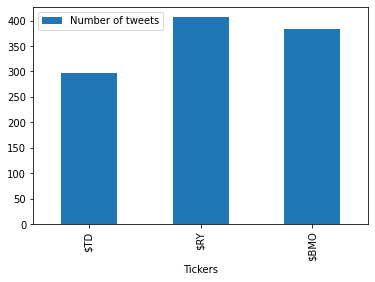

In [73]:
visualization_df = pd.DataFrame({'Tickers':tickers, 'Number of tweets':num_tweets_in_past_day})
ax = visualization_df.plot.bar(x='Tickers', y='Number of tweets', rot=90)

### Number of users tweeting in the past day for ticker symbol

In [77]:
start_date='2022-05-28'

end_date='2022-05-29'

num_distinct_users_in_past_day = []

for ticker in tickers:

    mask = (df['Created At'] > start_date) & (df['Created At'] <= end_date) & (df['Tickers'] == ticker)    
    num_users = df.loc[mask]
    n = len(pd.unique(num_users['User']))
    num_distinct_users_in_past_day.append(n)

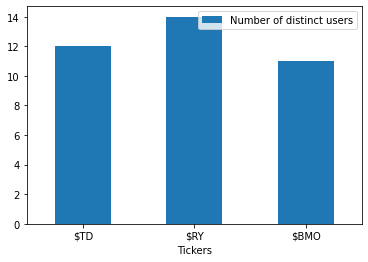

In [79]:
visualization2_df = pd.DataFrame({'Tickers':tickers, 'Number of distinct users':num_distinct_users_in_past_day})
ax = visualization2_df.plot.bar(x='Tickers', y='Number of distinct users', rot=0)

# 7. SQL Analytics Question

**Instructions**
---------------------

1. Use your own GCP account
2. Get sample data from BQ

- GA Dataset - https://support.google.com/analytics/answer/4419694?hl=en#zippy=%2Cin-this-article

3. BQ analytical queries

- BQ Cookbook - https://support.google.com/analytics/answer/7586738?hl=en#zippy=%2Cin-this-article

4. **Question**: How do you derive customers insights from GA data (feel free to perform data integration and build reprots!)

5. **Evaluation criteria for this exercise**: 
- SQL, 
- Working with nested fields, 
- Analytical expertise

6. **Deliverable artifacts**: Powerpoint deck summarizing methodology and findings along with queries

---------------------


### Problem statement
The dataset provides 12 months (August 2016 to August 2017) of obfuscated Google Analytics 360 data from the Google Merchandise Store , a real ecommerce store that sells Google-branded merchandise, in BigQuery. It’s a great way analyze business data and learn the benefits of using BigQuery to analyze Analytics 360 data Learn more about the data 
The data includes The data is typical of what an ecommerce website would see and includes the following information:

- **Traffic source data**: information about where website visitors originate, including data about organic traffic, paid search traffic, and display traffic
- **Content data**: information about the behavior of users on the site, such as URLs of pages that visitors look at, how they interact with content, etc.
- **Transactional data**: information about the transactions on the Google Merchandise Store website.

Data for some fields is obfuscated such as fullVisitorId, or removed such as clientId, adWordsClickInfo and geoNetwork. “Not available in demo dataset” will be returned for STRING values and “null” will be returned for INTEGER values when querying the fields containing no data.

**About GA Sessions**: For each Analytics view that is enabled for BigQuery integration, a dataset is added using the view ID as the name.

**Schema description**: https://support.google.com/analytics/answer/3437719?hl=en&ref_topic=3416089

In [223]:
!export GOOGLE_APPLICATION_CREDENTIALS="uol-datascience-341918-32809f524c18.json"

In [222]:
# Authentication
import os
from google.cloud import bigquery
from google.oauth2 import service_account
# Set environment variable
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./uol-datascience-341918-32809f524c18.json"
# Project name
project_id = "uol-datascience"
# Path to the key
key_path="./uol-datascience-341918-32809f524c18.json"
#Credentials
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)
#Instantiate BQ client
client = bigquery.Client(credentials=credentials, project=credentials.project_id)
# ROCK AND ROLLLLLL

In [224]:
# Perform a query.
q = (
"""
SELECT  fullVisitorId,
        visitNumber,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170710` LIMIT 1000
"""
)
query_job = client.query(q)  # API request
rows = query_job.result()  # Waits for query to finish, ADD CHECKS FOR FAILED QUERY

#  Create a pandas DataFrame by loading all pages of a query 
# https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.table.RowIterator.html
rows_df = rows.to_dataframe(create_bqstorage_client=True) 

In [225]:
print(rows_df)

           fullVisitorId  visitNumber
0    6131429996146284901            1
1    6332799276550005754            1
2    1217531208632585477            1
3     358414482172594579            1
4    1631409567299872036            1
..                   ...          ...
995   359543390044601586            1
996  3590334566572045711            1
997  9515230126025032270            1
998  4492737792188874011            1
999  6708420619872985019            1

[1000 rows x 2 columns]


### 1. Show the session count for all visitors who landed on our website on July 10, 2017. 

In [ ]:
# The unique visitor ID
# The session number for this user. If this is the first session, then this is set to 1.
"""
SELECT  fullVisitorId,
        visitNumber,
 FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170710` LIMIT 1000
"""

### 2. Summary of daily session statistics (concat df, axis=0) in the last x days/months/years 

totals: This section contains aggregate values across the session

totals.visits: The number of sessions (for convenience). This value is 1 for sessions with interaction events. The value is null if there are no interaction events in the session.

totals.pageviews: Total number of pageviews within the session.

totals.transactions: Total number of ecommerce transactions within the session.

totals.transactionRevenue: 	This field is deprecated. Use "totals.totalTransactionRevenue" instead (see above).


In [ ]:
"""
#standardSQL
SELECT
date,
SUM(totals.visits) AS visits,
SUM(totals.pageviews) AS pageviews,
SUM(totals.transactions) AS transactions,
SUM(totals.transactionRevenue)/1000000 AS revenue
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
_TABLE_SUFFIX BETWEEN FORMAT_DATE('%Y%m%d',DATE_SUB(CURRENT_DATE(), INTERVAL 1095 DAY))
AND
FORMAT_DATE('%Y%m%d',DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY))
GROUP BY date
ORDER BY date ASC
"""

### 3 Average bounce rate per [dimension]


In [ ]:
#standardSQL

"""
SELECT
source,
total_visits,
total_no_of_bounces,
( ( total_no_of_bounces / total_visits ) * 100 ) AS bounce_rate
FROM(
SELECT
trafficSource.source AS source,
COUNT ( trafficSource.source ) AS total_visits,
SUM ( totals.bounces ) AS total_no_of_bounces,
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
GROUP BY
source) 
ORDER BY
total_visits DESC
"""


#### Deriving Customer insights
We want to study customer and anonymous behavior across many sessions visitors have had on our website.

We are searching for behaviors that drive critical business decisions. The idea and techniques to customer segmentation are pivotal to understand customer insights.

Examples of user profiles we may be interested in:
- Users who did not make a purchase
- Users that made a purchase

### 4. Average number of product pageviews by !purchaser type! (buyer vs non-purchasers)
What was the average number of product pageviews for users who made a purchase in July 2017?

fullVisitorId: The unique visitor ID.
    
totals.pageviews: Total number of pageviews **within the session**.
    
totals.transactions: Total number of ecommerce transactions **within the session**.

In [ ]:
"""
#standardSQL
SELECT
( SUM(total_pagesviews_per_user) / COUNT(users) ) AS avg_pageviews_per_user
FROM
SELECT
fullVisitorId AS users,
SUM(totals.pageviews) AS total_pagesviews_per_user
FROM`bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
_TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
AND
totals.transactions >=1
GROUP BY
users )
"""

**Result:**

Average number of product pageviews for users who made a purchase in July 2017
27.720954356846473

Average number of product pageviews for users who did not make a purchase in July 2017
4.1918408747077427

This informs us that people who have the intention to buy typically conduct thorough research of the site before they make a purchase.

### 5. Average number of transactions per purchase

In [ ]:
What was the average total transactions per user that made a purchase in July 2017?

In [ ]:
"""
#standardSQL
SELECT
(SUM (total_transactions_per_user) / COUNT(fullVisitorId) ) AS avg_total_transactions_per_user
FROM (
SELECT
fullVisitorId,
SUM (totals.transactions) AS total_transactions_per_user
FROM
`bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
_TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
AND totals.transactions IS NOT NULL
GROUP BY
fullVisitorId )
"""

avg_total_transactions_per_user = 
1.1120331950207469

### 6. Average amount of money spent per session
What is the average amount of money spent per session in July 2017?

In [ ]:
"""
#standardSQL
SELECT
( SUM(total_transactionrevenue_per_user) / SUM(total_visits_per_user) ) AS
avg_revenue_by_user_per_visit
FROM (
SELECT
fullVisitorId,
SUM( totals.visits ) AS total_visits_per_user,
SUM( totals.transactionRevenue ) AS total_transactionrevenue_per_user
FROM
`bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
_TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
AND
totals.visits > 0
AND totals.transactions >= 1
AND totals.transactionRevenue IS NOT NULL
GROUP BY
fullVisitorId )
"""

In [12]:
avg_revenue_by_user_per_visit = 120755848.69059166
print(f"Visitors that land on the Google merch site on average will generate ${avg_revenue_by_user_per_visit / pow(10, 6)}")


Customers and anons that land on the Google merch site on average will generate $120.75584869059166
